## Basic Imports

In [1]:
import logging
logging.basicConfig(
    level=logging.INFO
)

from pathlib import Path

## Testing reaction class

In [2]:
from kinetics.containers import ElementaryReaction

rxn = ElementaryReaction(
    reactants=['A', 'B_1'],
    products=['C_12', 'D'],
    rate_const_key='k_12_FabG',
    rate_const_value=3.14E-5,
)

In [3]:
print( rxn.reaction_expression(arrow_stem='=') )
print( str(rxn.reversed(k_rev_value=12)) )

A + B_1 ==[k_12_FabG]==> C_12 + D
C_12 + D ==[k_12_FabG_rev]==> A + B_1


In [4]:
rxn.to_file('test.json')
r2 = rxn.from_file('test.json')
print(r2)

A + B_1 ==[k_12_FabG]==> C_12 + D


# Creating and compiling reaction networks

## Define reactions in network

In [5]:
# defines custom scaling factors to be applied to rate constants in post
SCALING_GROUPS : dict[int, float] = { 
    0 : 1.2,
}

# define reactions
r_fwd = ElementaryReaction(
    reactants=['A'],
    products=['B'],
    rate_const_key='k_f',
    rate_const_value=5.5,
    name='forward_rxn',
)
r_back = r_fwd.reversed(k_rev_value=3.0, k_rev_key='k_r', rev_name='reverse_rxn')
r_side = ElementaryReaction(
    reactants=['A', 'A'],
    products=['S'],
    rate_const_key='k_side',
    rate_const_value=1.2,
    name='sideproduct_rxn',
    scaling_group_id=0
)

## Write reactions to files on disc

In [6]:
rxns_orig = [
    r_fwd, 
    r_back, 
    r_side,
]

rxn_dir = Path('rxnfiles')
rxn_dir.mkdir(exist_ok=True)

for rxn in rxns_orig:
    rxn_path = rxn_dir / f'{rxn.name}.json'
    rxn.to_file(rxn_path)

## Compiling reaction network from files

In [7]:
from kinetics.reactions import compile_reaction_network, compute_rate_const_tensors




rxns_loaded = [ # load all reaction JSON files in the desired directory
    ElementaryReaction.from_file(rxnpath)
        for rxnpath in rxn_dir.glob('*.json')
]

# compile unique species and rate constants
rate_consts, contrib = compile_reaction_network(rxns_loaded)

n_species = 0
species_by_idx = {}
idxs_by_species = {}
for i, species_name in enumerate(contrib.keys()):
    species_by_idx[i] = species_name
    idxs_by_species[species_name] = i
    n_species += 1

rate_const_tensors = compute_rate_const_tensors(contrib, idxs_by_species=idxs_by_species, scaling_groups=SCALING_GROUPS)

INFO:kinetics.reactions:B : k_f*A + -k_r*B
INFO:kinetics.reactions:A : k_r*B + -k_f*A + -k_side*A*A
INFO:kinetics.reactions:S : k_side*A*A


# Integrating system of ODEs

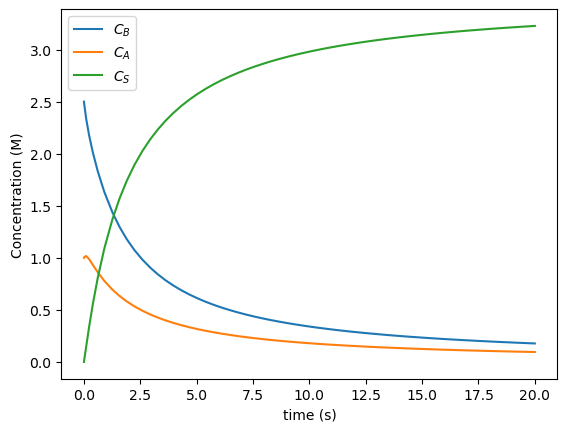

In [9]:
import matplotlib.pyplot as plt
from kinetics.solvers import integrate_reaction_network

C0 = { # you only have to explicitly set concs for species whose initial concs are non-zero
    'A' : 1.0,
    'B' : 2.5,
    # for example, the sideproduct species "S" will be inplicitly set to have 0 initial concentration
}
solution = integrate_reaction_network(init_nonzero_concs=C0, rate_const_tensors=rate_const_tensors, idxs_by_species=idxs_by_species, t0=0.0, tf=20.0, method='RK45')

fig, ax = plt.subplots()
for i, curve in enumerate(solution.y):
    ax.plot(solution.t, curve, label=f'$C_{species_by_idx[i]}$')
ax.set_xlabel('time (s)')
ax.set_ylabel('Concentration (M)')
ax.legend()

plt.show()